In [1]:
# preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from imblearn.over_sampling import RandomOverSampler
import pandas as pd
import regex as re
import html
# machine learning
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN,Reshape
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from tensorflow import string
from tensorflow_hub import KerasLayer
# evaluation
import sklearn.metrics as metrics
# visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
psy = pd.read_csv('datasets/Youtube01-Psy.csv')
katy_perry = pd.read_csv('datasets/Youtube02-KatyPerry.csv')
lmfao = pd.read_csv('datasets/Youtube03-LMFAO.csv')
eminem = pd.read_csv('datasets/Youtube04-Eminem.csv')
shakira = pd.read_csv('datasets/Youtube05-Shakira.csv')
# combine kaggle datasets
df_1 = pd.concat([psy, katy_perry, lmfao, eminem, shakira], ignore_index=True)
# select relevant features
df_1 = df_1[['CONTENT', 'CLASS']]
# rename features
df_1 = df_1.rename(columns={'CONTENT': 'comment', 'CLASS': 'target'})
# additional datasets
df_2 = pd.read_csv('datasets/comments_1.csv')
df_2 = df_2[['Comment', 'Spam']]
df_2 = df_2.rename(columns={'Comment': 'comment', 'Spam': 'target'})
# combine datasets
df = pd.concat([df_1, df_2], ignore_index=True)
df.head()

,comment,target
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


Not Spam: 3451
Spam: 3505


<AxesSubplot:xlabel='target', ylabel='count'>

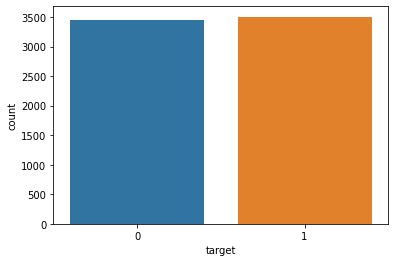

In [3]:
print(f"Not Spam: {len(df[df['target'] == 0])}")
print(f"Spam: {len(df[df['target'] == 1])}")
sns.countplot(x='target', data=df)

In [4]:
en_stopwords = stopwords.words('english')
lemmatizer = WordNetLemmatizer()

def pre_process(text):
    '''
    - remove HTML entities, HTML tags, stopwords
    - leave link keywords from URL's ("http" & "www")
    - latin characters only
    - word tokenization
    - lemmatization
    - lowercase
    '''
    html_entities_removed = html.unescape(text.lower())
    html_tags_removed = re.sub('<.*?>', ' ', html_entities_removed)
    link_keywords = re.sub(r'(?<=(http|[wW]{3}))\S+', ' ', html_tags_removed)
    nonlatin_chars_removed = re.sub(r'[^A-Za-z\s]+', '  ', link_keywords)
    tokenized = word_tokenize(nonlatin_chars_removed)
    stopwords_removed = [word for word in tokenized if not word in en_stopwords]
    lemmatized = [lemmatizer.lemmatize(word) for word in stopwords_removed]
    output = ' '.join(lemmatized)
    
    return output

df['cleaned'] = df['comment'].apply(pre_process)
df = df[['comment','cleaned', 'target']]
df = df.replace('', float('NaN')).dropna().drop_duplicates()
df

,comment,cleaned,target
0,"Huh, anyway check out this you[tube] channel: ...",huh anyway check tube channel kobyoshi,1
1,Hey guys check out my new channel and our firs...,hey guy check new channel first vid u monkey m...,1
2,just for test I have to say murdev.com,test say murdev com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,shaking sexy as channel enjoy,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,watch v vtarggvgtwq check,1
...,...,...,...
6951,She is so beautiful!,beautiful,0
6952,3 seconds in and I want to marry her. I am goi...,second want marry going need explain block cha...,0
6953,She talks a lot like Tanmay Bakshi,talk lot like tanmay bakshi,0
6954,Why does her face look like a bad deepfake?,face look like bad deepfake,0


In [5]:
df=df[['cleaned', 'target']]
df

,cleaned,target
0,huh anyway check tube channel kobyoshi,1
1,hey guy check new channel first vid u monkey m...,1
2,test say murdev com,1
3,shaking sexy as channel enjoy,1
4,watch v vtarggvgtwq check,1
...,...,...
6951,beautiful,0
6952,second want marry going need explain block cha...,0
6953,talk lot like tanmay bakshi,0
6954,face look like bad deepfake,0


In [6]:
X = df['cleaned'].values
y = df['target'].values
# oversample spam data to balance dataset
ros = RandomOverSampler(random_state=42)
X, y = ros.fit_resample(X.reshape(-1, 1), y.reshape(-1, 1))
# 80/10/10 - training/validation/testing
# split dataset ito training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# further split training dataset into training and validation
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)
X_val=X_test
y_val = y_test

print(f'Size: {len(X)}')
print(f'Training Size: {len(X_train)}')
print(f'Validation Size: {len(X_val)}')
print(f'Testing Size: {len(X_test)}')

Size: 6748
Training Size: 5398
Validation Size: 675
Testing Size: 675


In [7]:
model = Sequential()
model.add(KerasLayer('nnlm_en_dim50_2', input_shape=[], dtype=string, trainable=True))
model.add(Reshape((1,50)))
model.add(SimpleRNN(64))
model.add(Dense(40, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 reshape (Reshape)           (None, 1, 50)             0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                7360      
                                                                 
 dense (Dense)               (None, 40)                2600      
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 48,200,601
Trainable params: 48,200,601
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.compile(
	optimizer=Adam(learning_rate=0.001),
	loss='binary_crossentropy',
	metrics=['accuracy']
)
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=1, restore_best_weights=True)
hist = model.fit(
	X_train,
	y_train,
	epochs=50,
	batch_size=32,
	validation_data=(X_val, y_val),
	callbacks=[early_stop]
)

# save model
model.save('spam_detector')

Epoch 1/50
44/44 [==============================] - 4s 57ms/step - loss: 0.5607 - accuracy: 0.7939 - val_loss: 0.3746 - val_accuracy: 0.9022
Epoch 2/50
44/44 [==============================] - 2s 49ms/step - loss: 0.2421 - accuracy: 0.9218 - val_loss: 0.2030 - val_accuracy: 0.9303
Epoch 3/50
44/44 [==============================] - 2s 50ms/step - loss: 0.1136 - accuracy: 0.9638 - val_loss: 0.1775 - val_accuracy: 0.9353
Epoch 4/50
44/44 [==============================] - 2s 49ms/step - loss: 0.0651 - accuracy: 0.9837 - val_loss: 0.1698 - val_accuracy: 0.9370
Epoch 5/50
44/44 [==============================] - 2s 48ms/step - loss: 0.0414 - accuracy: 0.9908 - val_loss: 0.1786 - val_accuracy: 0.9370
Epoch 5: early stopping
INFO:tensorflow:Assets written to: spam_detector_70/30_dataset\assets


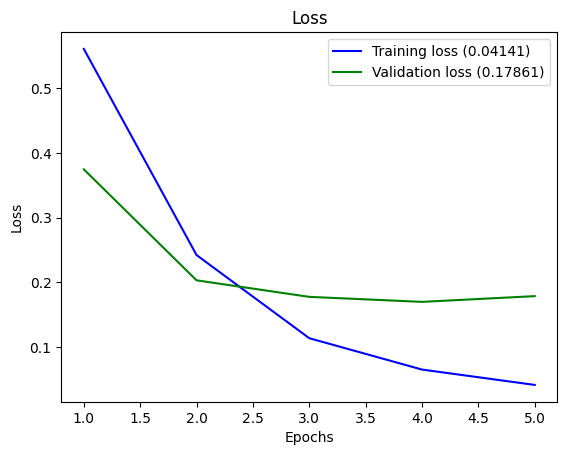

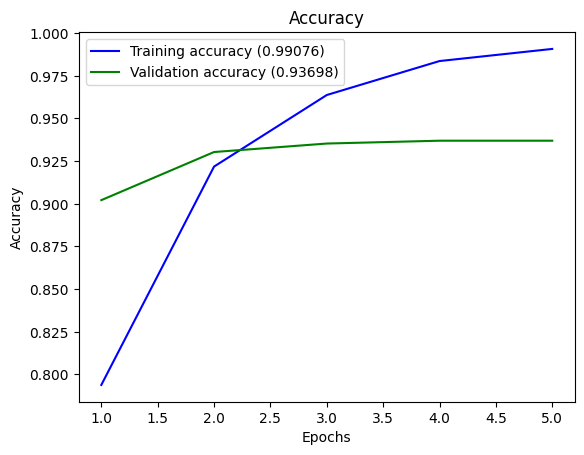

In [13]:
# plot loss and accuracy
loss_list = [s for s in hist.history.keys() if 'loss' in s and 'val' not in s]
val_loss_list = [s for s in hist.history.keys() if 'loss' in s and 'val' in s]
acc_list = [s for s in hist.history.keys() if 'acc' in s and 'val' not in s]
val_acc_list = [s for s in hist.history.keys() if 'acc' in s and 'val' in s]

epochs = range(1, len(hist.history[loss_list[0]]) + 1)

# loss
plt.figure(1)
for l in loss_list:
    plt.plot(epochs, hist.history[l], 'b', label='Training loss (' + str(str(format(hist.history[l][-1],'.5f'))+')'))
for l in val_loss_list:
    plt.plot(epochs, hist.history[l], 'g', label='Validation loss (' + str(str(format(hist.history[l][-1],'.5f'))+')'))

plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.figure(2)
for l in acc_list:
    plt.plot(epochs, hist.history[l], 'b', label='Training accuracy (' + str(format(hist.history[l][-1],'.5f'))+')')
for l in val_acc_list:    
    plt.plot(epochs, hist.history[l], 'g', label='Validation accuracy (' + str(format(hist.history[l][-1],'.5f'))+')')

plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
# make predictions using the model
y_pred = model.predict([X_test], verbose=0)
# convert the predicted values to binary classes
y_pred = (y_pred > 0.6).astype(int)

# confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)

TN = cm[0][0]
TP = cm[1][1]
FP = cm[0][1]
FN = cm[1][0]

# calculate evaluation metrics
accuracy = round(metrics.accuracy_score(y_test, y_pred) * 100, 2)
precision = round(metrics.precision_score(y_test, y_pred) * 100, 2)
recall = round(metrics.recall_score(y_test, y_pred) * 100, 2)
f1_score = round(metrics.f1_score(y_test, y_pred) * 100, 2)
mcc= round(metrics.matthews_corrcoef(y_test, y_pred) * 100, 2)

print(f'Accuracy: {accuracy}%')
print(f'Precision: {precision}%')
print(f'SC/Recall: {recall}%')
print(f'BH/FPR: {round(FP/(FP+TN),3)}')
print(f'F1 Score: {f1_score}%')
print(f'MCC: {mcc}%')

Accuracy: 93.7%
Precision: 95.25%
SC/Recall: 92.13%
BH/FPR: 0.047
F1 Score: 93.67%
MCC: 87.45%


<AxesSubplot:>

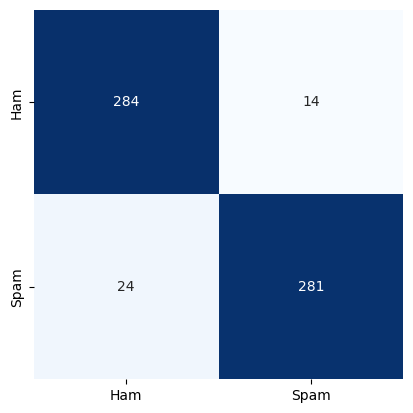

In [ ]:
# heatmap
sns.heatmap(cm,
            square=True,
            annot=True,
            cmap='Blues',
            fmt='d',
            xticklabels=['Ham','Spam'],
            yticklabels=['Ham','Spam'],
            cbar=False
)

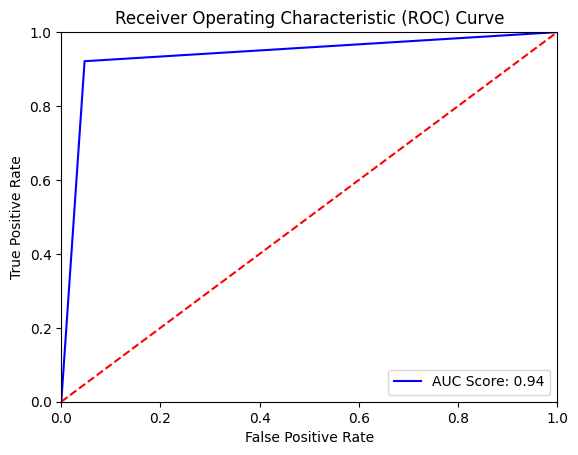

In [17]:
# ROC curve
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
auc_score = round(metrics.roc_auc_score(y_test, y_pred), 2)

plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot(fpr, tpr, 'b', label=f'AUC Score: {auc_score}')
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()